In [1]:
import os
import sys
current_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
import numpy as np              # Python's standard numerical library
import matplotlib.pyplot as plt # Python's scientific visualization library
from pyidi import ROISelect
from matplotlib.path import Path
import pickle as pk
from pixel_setter import play_video
from scipy.ndimage import uniform_filter
from EMA_functions import *
from Feature_selecter import *
root_drive_sim = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Simulations')


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# file_name =  '0_nad_1'
file_name = 'measurement_0_00_degres_S01'
EMA_structure = EMA_Structure(file_name + '.cihx')
video = EMA_structure.open_video(add_extension=False)
video.info

D:/thijsmas/HSC - Ladisk\transfer_100504_files_37b9d3ac\measurement_0_00_degres_S01.cihx


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 40000, Original total frame: 49925)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


{'Date': '2023/5/9',
 'Camera Type': 'FASTCAM SA-Z type 2100K-M-64GB',
 'Record Rate(fps)': 20000.0,
 'Shutter Speed(s)': 20664.0,
 'Total Frame': 40000,
 'Original Total Frame': 49925,
 'Image Width': 896,
 'Image Height': 1024,
 'File Format': 'Mraw',
 'EffectiveBit Depth': 12,
 'EffectiveBit Side': 'Higher',
 'Color Bit': 16,
 'Comment Text': ''}

C:\Users\thijsmas\Documents\GitHub\pyidi\pyidi\pyidi.py:275: DeprecationWarning: `self.mraw` is deprecated and will be removed in the next version. Please use `self.reader.mraw` instead.
  warnings.warn('`self.mraw` is deprecated and will be removed in the next version. Please use `self.reader.mraw` instead.', DeprecationWarning)


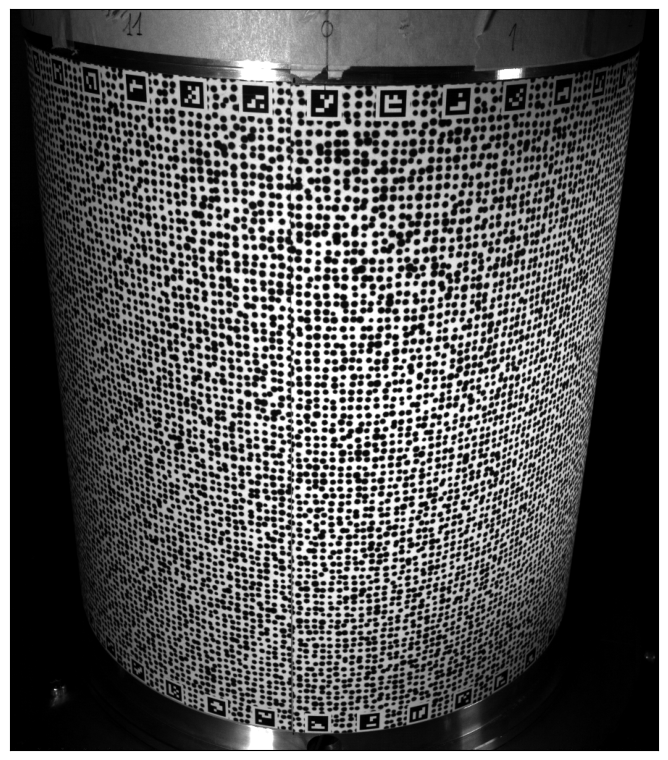

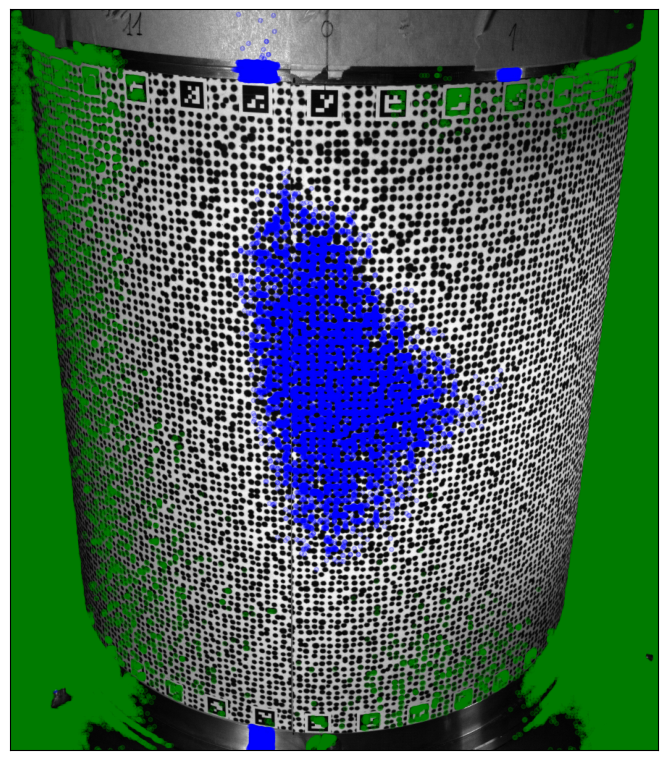

In [3]:
%matplotlib inline
sequential_image_n = 0
still_image = video.mraw[sequential_image_n]

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=False, bit_depth = 16)
# fig.savefig(os.path.join(root_drive_sim, 'still images', f'{file_name}_frame_sat0.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=True, bit_depth = 16)
# fig.savefig(os.path.join(root_drive_sim, 'still images','with saturation', f'{file_name}_frame_sat1.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

In [4]:
# roi_select = ROISelect(video)
# roi_select.polygon
# polygon = np.array(roi_select.polygon)
polygon = np.array([[ 57,  92, 112, 111, 105,  94,  74, 835, 917, 982, 985, 953, 903,
        846, 812,  57],
       [ 23, 178, 402, 586, 689, 796, 858, 766, 702, 551, 360, 247, 158,
        101,  81,  23]])#Polygon for shell
# polygon = np.array([[617, 656, 491,  74, 138, 215, 617],
#        [621, 303,  48, 116, 434, 734, 621]]) #Polygon for inverted cube

In [5]:
polygon

array([[ 57,  92, 112, 111, 105,  94,  74, 835, 917, 982, 985, 953, 903,
        846, 812,  57],
       [ 23, 178, 402, 586, 689, 796, 858, 766, 702, 551, 360, 247, 158,
        101,  81,  23]])

In [7]:
%matplotlib qt
first_frame = 1
ani = play_video(video, range(first_frame,video.reader.N - 1), interval=30)

C:\Users\thijsmas\Documents\GitHub\pyidi\pyidi\pyidi.py:275: DeprecationWarning: `self.mraw` is deprecated and will be removed in the next version. Please use `self.reader.mraw` instead.
  warnings.warn('`self.mraw` is deprecated and will be removed in the next version. Please use `self.reader.mraw` instead.', DeprecationWarning)


# Set points 2D

In [8]:
%matplotlib qt
# reference_image = (0, video.N)
# mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)
# np.save('mean_image.npy', mean_image)
mean_image = np.load('mean_image.npy')


In [13]:
roi_size = (3,3)
path = Path(polygon.T)
mask_image = path.contains_points(np.array([(i,j) for i in range(mean_image.shape[0]) for j in range(mean_image.shape[1])]))
mask_image = mask_image.reshape(mean_image.shape)
mean_image_masked = np.copy(mean_image)
mean_image_masked[~mask_image] = 0
# mean_image_masked[mean_image_masked > 2**16-20] = np.nan

n_tracking_points = 1000

feature_selecter = FeatureSelecter(mean_image_masked)
feature_selecter.set_filter_method('eig0', roi_size)
score_full = feature_selecter.apply_filter(downsample=1)
# maxima2d = feature_selecter.pick_max_filter(score_image = score_full, min_distance = roi_size, absolute_treshold = 0.0) #, top_n_points = n_tracking_points
# maxima2d = feature_selecter.pick_ANMS(score_image = score_full, n_points=n_tracking_points, c_robust=0.05)  
maxima2d = feature_selecter.pick_max_loop(score_image = score_full, min_distance = roi_size, n_points = n_tracking_points, minimum_score= 10)
feature_selecter.plot_score_image(maxima=True)

video.set_method('lk')
video.method.configure(roi_size = roi_size, reference_image = mean_image, resume_analysis=False) #, mraw_range=(1, 1000)
video.set_points(maxima2d)
video.show_points()
feature_selecter.maxima.shape

Available filter methods: eig0, eig1, harris, trigs, harmonic_mean, eig_theta, eig_theta_off, eig0_test, eig1_test


(1000, 2)

In [ ]:
displacement = video.get_displacements() #processes = 24
EMA_structure.displacements = displacement
EMA_structure.maxima = maxima2d
EMA_structure.mean_image = mean_image
EMA_structure.score_image = score_full
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
path = os.path.join(root, 'EMA structure', file_name+f'_2d_roi{roi_size[0]}x{roi_size[1]}.pkl')
with open(path, 'wb') as f:
    pk.dump(EMA_structure, f)

In [ ]:
%matplotlib qt
td     = displacement +  maxima2d.reshape(len(maxima2d),1,2)
ani = play_video(video, range(1000, video.N-1), interval=30, points=td, axis=([0, video.info['Image Width']],[video.info['Image Height'], 0]))

## Set points 1D

In [ ]:
%matplotlib qt
theta_vec = np.linspace(0, np.pi, 5)
theta_vec = theta_vec[:-1]
theta_vec = np.append(theta_vec, 1.5730517285207863)

# roi_size = (5,5)
roi_size = (9,9)
# n_tracking_points = 1000
Gi, Gj = np.gradient(mean_image_masked)
for theta in theta_vec:
    s = np.array([np.cos(theta), np.sin(theta)])
    Gs  = np.abs(s[0]*Gj + s[1]*Gi)
    filtered_image = uniform_filter(Gs, size=roi_size[0])
    # maxima1d = feature_selecter.pick_max_filter(score_image = filtered_image, min_distance = roi_size[0], absolute_treshold = None, threshold_percentage = 0, top_n_points = n_tracking_points)
    # maxima1d = feature_selecter.pick_ANMS(score_image = filtered_image, n_points=n_tracking_points, c_robust=0.05)
    maxima1d = feature_selecter.pick_max_loop(score_image = filtered_image, min_distance = roi_size, n_points = n_tracking_points, minimum_score= 10)
    feature_selecter.plot_score_image(maxima=True)
    video.set_method('lk_1D')
    video.method.configure(roi_size = roi_size, d = s,  reference_image = mean_image, resume_analysis=False) #, mraw_range=(1, 1000)
    video.set_points(maxima1d)
    video.show_points()

    displacement_1d = video.get_displacements(processes=24)
    EMA_structure.displacements = displacement_1d
    EMA_structure.maxima = maxima1d
    EMA_structure.mean_image = mean_image
    root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
    path = os.path.join(root, 'EMA structure', file_name+f'_1d_roi{roi_size[0]}x{roi_size[1]}_theta{theta}.pkl')
    with open(path, 'wb') as f:
        pk.dump(EMA_structure, f)


In [ ]:
video.set_method('lk_1D')
d = (0,1)
video.method.configure(roi_size = roi_size, d = d, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
video.set_points(maxima1d[mask_points])

In [ ]:
displacement_1d = video.get_displacements(processes=24)
EMA_structure.displacements = displacement
EMA_structure.maxima = maxima1d
EMA_structure.mean_image = mean_image
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
path = os.path.join(root, 'EMA structure', file_name+f'_1d_roi{roi_size[0]}x{roi_size[1]}.pkl')
with open(path, 'wb') as f:
    pk.dump(EMA_structure, f)

In [ ]:
roi_size_2d = (7,7)
roi_size_1d = (3,3)
reference_image = (0, 150)
n_tracking_points_1d = 6000
n_tracking_points_2D = 6000
Polygon = Path(polygon.T)
d = (0,1)
s = np.array([0,1])
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'

for path_c in path_list:
    file_name = os.path.basename(path_c)
    EMA_structure = EMA_Structure(file_name[:-5] + '.cih')
    video = EMA_structure.open_video(add_extension=False)

    mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)

    feature_selecter = FeatureSelecter(mean_image)
    feature_selecter.set_filter_method('eig0', roi_size_2d)
    score_full = feature_selecter.apply_filter(downsample=1)
    maxima2d = feature_selecter.pick_max_filter(score_image = score_full, min_distance = roi_size_2d, absolute_treshold = 0.0) #, top_n_points = n_tracking_points
    mask_points = Polygon.contains_points(maxima2d)

    video.set_method('lk')
    video.method.configure(roi_size = roi_size_2d, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
    video.set_points(maxima2d[mask_points])

    displacement = video.get_displacements(processes = 24)
    EMA_structure.displacements = displacement
    EMA_structure.maxima = maxima2d[mask_points]
    EMA_structure.mean_image = mean_image
    
    path = os.path.join(root, 'EMA structure', file_name+f'_2d_roi{roi_size_2d[0]}x{roi_size_2d[1]}.pkl')
    with open(path, 'wb') as f:
        pk.dump(EMA_structure, f)
    
    Gi, Gj = np.gradient(mean_image)
    
    Gs  = s[0]*Gj + s[1]*Gi
    filtered_image = uniform_filter(Gs, size=roi_size_1d[0])
    maxima1d = feature_selecter.pick_max_filter(score_image = Gi, min_distance = roi_size_1d[0], absolute_treshold = None, threshold_percentage = 0, top_n_points = n_tracking_points)

    mask_points = Polygon.contains_points(maxima1d)
    video.set_method('lk_1D')
    video.method.configure(roi_size = roi_size_1d, d = d, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
    video.set_points(maxima1d[mask_points])

    displacement = video.get_displacements(processes=24)
    EMA_structure.displacements = displacement
    EMA_structure.maxima = maxima1d[mask_points]
    EMA_structure.mean_image = mean_image

    path = os.path.join(root, 'EMA structure', file_name+f'_1d_roi{roi_size_1d[0]}x{roi_size_1d[1]}.pkl')
    with open(path, 'wb') as f:
        pk.dump(EMA_structure, f)
